# Natural Language Processing with Disaster Tweets

**Natural Language Processing (NLP)** is a subfield of linguistics, computer science, and artificial intelligence concerned with the interactions between computers and human (natural) languages. It aims to enable computers to understand, interpret, and generate human language in a way that is both valuable and meaningful. NLP combines computational linguistics—rule-based modeling of human language—with statistical, machine learning, and deep learning models. These technologies enable computers to process human language in the form of text or voice data and to 'understand' its full meaning, complete with the speaker or writer's intent and sentiment. NLP is used in a wide range of applications, including language translation, sentiment analysis, chatbots, voice-activated assistants, information retrieval, and summarization. The field is at the heart of making human-computer interactions as seamless and natural as possible, bridging the gap between human communication and computer understanding

**Project Goal and description of data**

Project goal is to analyze tweets classifying them into disaster and non-disaster ones to extract useful information during crises. We are predicting whether a given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0.

We are given three files:
train.csv - the training set

test.csv - the test set

sample_submission.csv - a sample submission file in the correct format.

Columns
id - a unique identifier for each tweet

text - the text of the tweet

location - the location the tweet was sent from (may be blank)

keyword - a particular keyword from the tweet (may be blank)

target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Flatten, Dropout
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from collections import Counter
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
import numpy as np
import tensorflow as tf
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, GlobalMaxPool1D, BatchNormalization, Dropout, Dense, Input
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Flatten, Dense
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk import download
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

2024-04-09 14:01:29.929182: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-09 14:01:29.929332: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-09 14:01:30.063551: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Exploratory Data Analysis (EDA)

**Loading data**

In [3]:
train_path = "/kaggle/input/nlp-getting-started/train.csv"
test_path = "/kaggle/input/nlp-getting-started/test.csv"

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


**Visualize data**

We will do following visualizations:

1. Plot distribution of target variable.
2. Word count distribution.
3. Character count distribution.
4. Common words in disaster tweets.


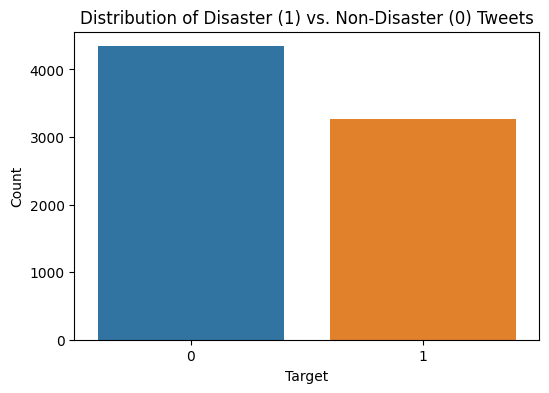

In [5]:
# Distribution of the Target Variable
plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=df_train)
plt.title('Distribution of Disaster (1) vs. Non-Disaster (0) Tweets')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

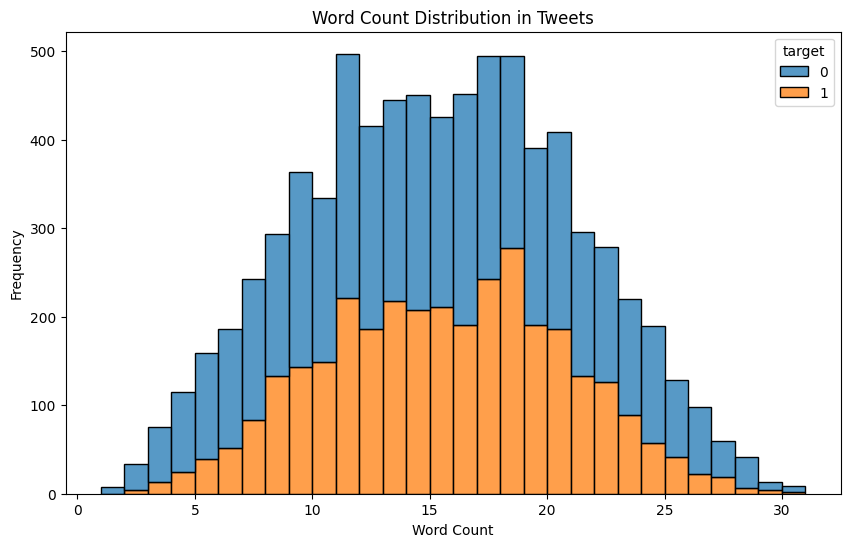

In [6]:
# Word Count Distribution
df_train['word_count'] = df_train['text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
sns.histplot(data=df_train, x='word_count', hue='target', multiple="stack", bins=30)
plt.title('Word Count Distribution in Tweets')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

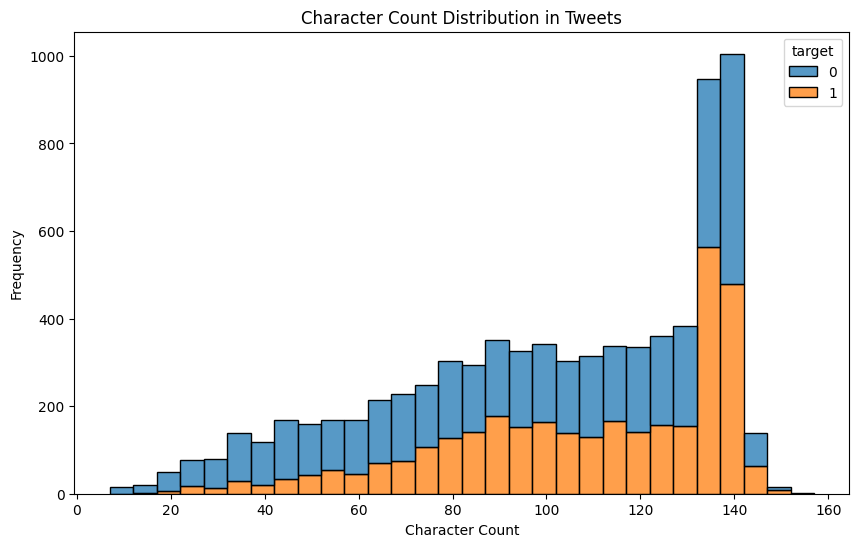

In [7]:
# Character Count Distribution
df_train['char_count'] = df_train['text'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(data=df_train, x='char_count', hue='target', multiple="stack", bins=30)
plt.title('Character Count Distribution in Tweets')
plt.xlabel('Character Count')
plt.ylabel('Frequency')
plt.show()

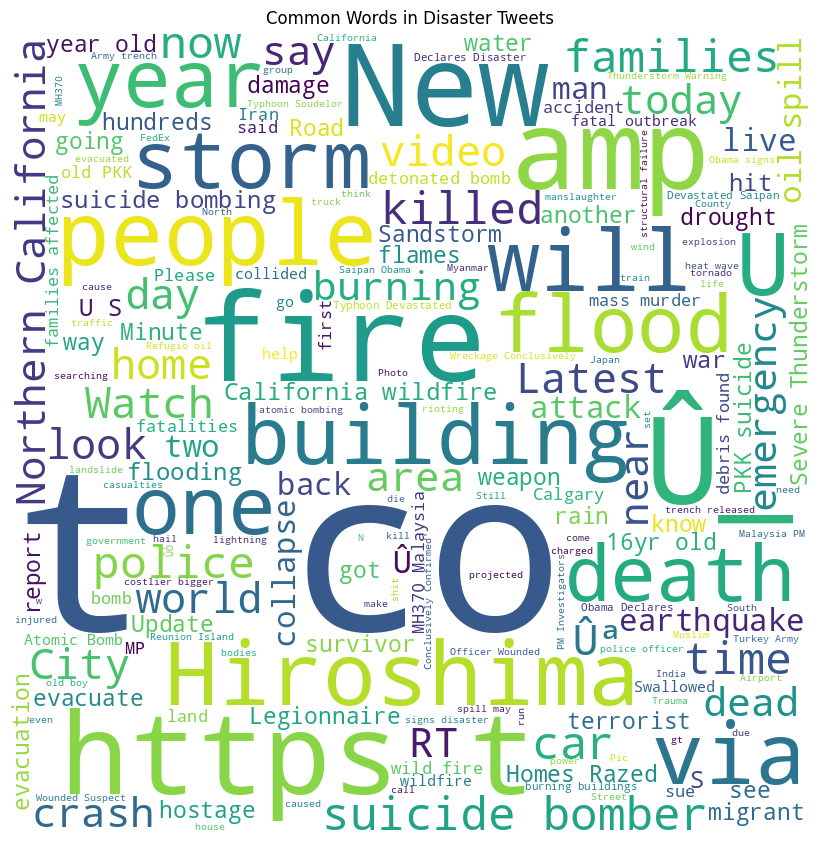

In [8]:
# Preparing data for the word cloud
disaster_tweets = ' '.join(df_train[df_train['target'] == 1]['text'])

# Generating a word cloud for disaster tweets
wordcloud_disaster = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = None, 
                min_font_size = 10).generate(disaster_tweets)

# Plotting the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud_disaster) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title('Common Words in Disaster Tweets')
plt.show()

# Data Preprocessing

We need to clean the data in order to create a model. We will remove URLs, HTML tags, emoticons, pictographs, map symbols etc.
I am using NLTK library to clean the data.

After cleaning the data, we will visualize top 50 words in disaster and non disaster tweets to get better idea of data.

In [9]:
# Download stopwords from NLTK
download('stopwords')

ps = PorterStemmer()
wl = WordNetLemmatizer()

def preprocess_data(data):
    review = re.sub(r'https?://\S+|www\.\S+|http?://\S+', ' ', data)  # Removal of URL
    review = re.sub(r'<.*?>', ' ', review)  # Removal of HTML tags
    review = re.sub("["
                    u"\U0001F600-\U0001F64F"  # Removal of emoticons
                    u"\U0001F300-\U0001F5FF"  # Symbols & pictographs
                    u"\U0001F680-\U0001F6FF"  # Transport & map symbols
                    u"\U0001F1E0-\U0001F1FF"  # Flags (iOS)
                    u"\U00002702-\U000027B0"
                    u"\U000024C2-\U0001F251"
                    "]+", ' ', review)
    review = re.sub('[^a-zA-Z]', ' ', review)  # Filtering out miscellaneous text
    review = review.lower()  # Lowering all the words in text
    review = review.split()
    review = [ps.stem(word) for word in review if word not in stopwords.words('english')]  # Stemming
    review = [i for i in review if len(i) > 2]  # Removal of words with length < 2
    review = ' '.join(review)
    return review

# Applying preprocessing to the text columns in both train and test datasets
df_train["Cleaned_text"] = df_train["text"].apply(preprocess_data)
df_test["Cleaned_text"] = df_test["text"].apply(preprocess_data)


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


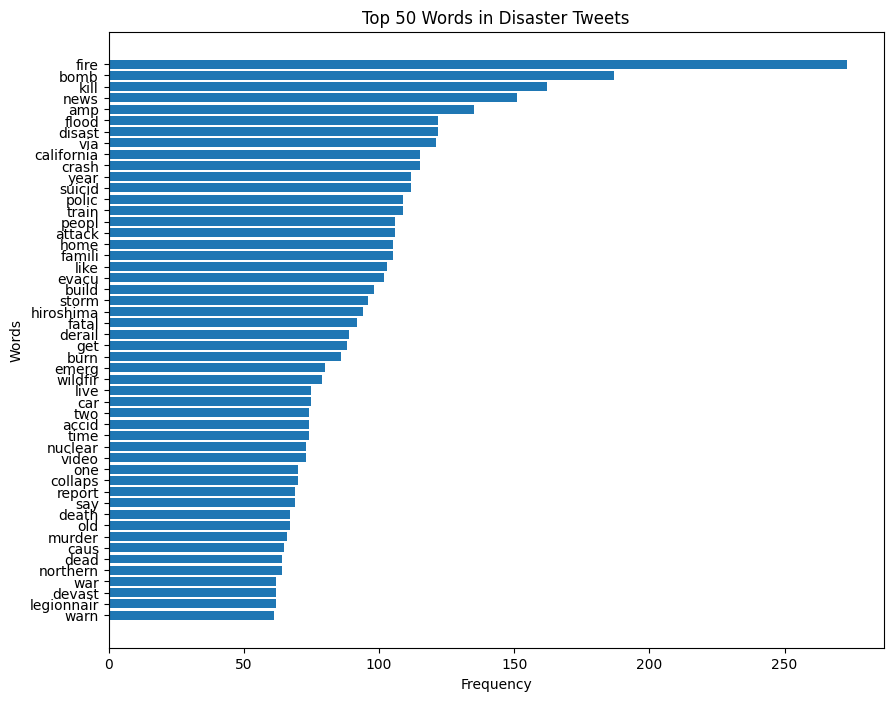

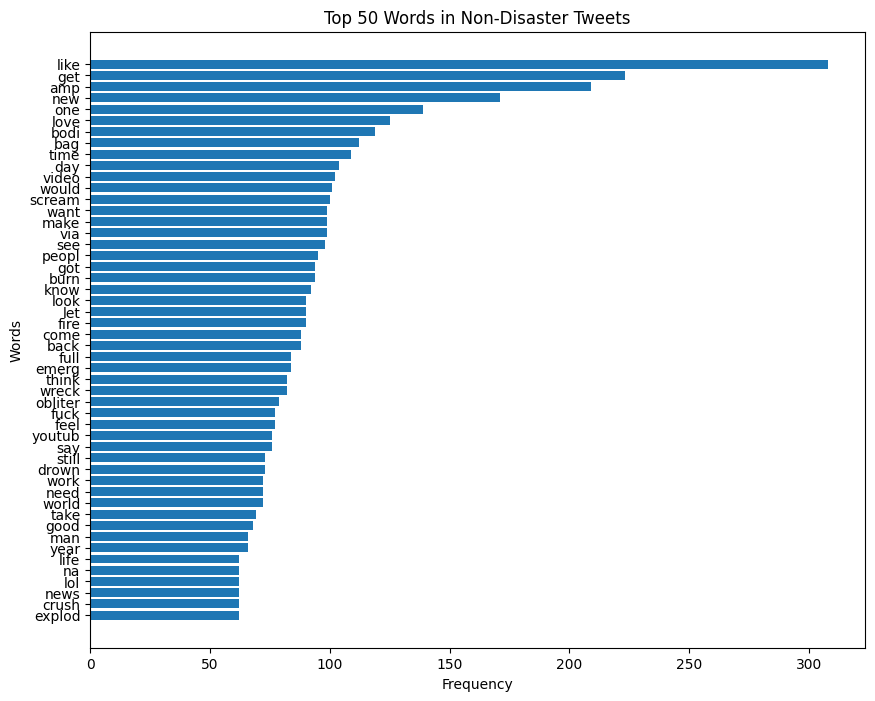

In [10]:

# Function to preprocess and get top words
def get_top_words(texts, n=50):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(' '.join(texts).lower())
    filtered_words = [word for word in word_tokens if word.isalpha() and word not in stop_words]
    most_common_words = Counter(filtered_words).most_common(n)
    return most_common_words

# Splitting the dataset into disaster and non-disaster tweets
disaster_texts = df_train[df_train['target'] == 1]['Cleaned_text']
non_disaster_texts = df_train[df_train['target'] == 0]['Cleaned_text']

# Getting top 50 words for each category
top_disaster_words = get_top_words(disaster_texts)
top_non_disaster_words = get_top_words(non_disaster_texts)

# Function to plot the words and their counts
def plot_top_words(top_words, title):
    words, counts = zip(*top_words)
    plt.figure(figsize=(10, 8))
    plt.barh(range(len(top_words)), counts, tick_label=words)
    plt.gca().invert_yaxis()  # To display the highest counts at the top
    plt.title(title)
    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.show()

# Plotting top 50 words for disaster tweets
plot_top_words(top_disaster_words, 'Top 50 Words in Disaster Tweets')

# Plotting top 50 words for non-disaster tweets
plot_top_words(top_non_disaster_words, 'Top 50 Words in Non-Disaster Tweets')


Not let's split the data into training and test set and preproess the data to create a model.

In [11]:
train_data, test_data = train_test_split(df_train, test_size = 0.2, random_state = 0)

In [12]:
# Tokenization
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")  # Only considering the top 5000 words
tokenizer.fit_on_texts(df_train['Cleaned_text'])
word_index = tokenizer.word_index

# Converting text to sequences of integers
train_sequences = tokenizer.texts_to_sequences(train_data['Cleaned_text'])
test_sequences = tokenizer.texts_to_sequences(test_data['Cleaned_text'])

# Padding sequences to ensure uniformity in sequence length
max_length = 100  # Maximum length of all sequences
padding_type = 'post'
trunc_type = 'post'

train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)


# Model Architecture

I built three models for this project.

**First Model**

After preparing the text data through a tokenization and padding process, a Sequential neural network model is constructed to handle the NLP task, specifically designed for binary classification. The model architecture is comprised of several layers, each serving a unique purpose in processing the textual data:

Embedding Layer: The first layer is an Embedding layer, which is crucial for NLP tasks. It transforms the integer-encoded vocabulary into dense vectors of fixed size, in this case, 128 dimensions. The input_dim is set to 5000, matching the tokenizer configuration to consider only the top 5000 words. This layer essentially maps many sparse vectors representing word indices into a lower-dimensional space where words with similar meanings have similar representations.

LSTM Layers: Following the embedding layer are two LSTM (Long Short-Term Memory) layers, each with 64 units. LSTM layers are a type of recurrent neural network (RNN) capable of learning long-term dependencies in sequence data. The return_sequences=True parameter in both LSTM layers ensures that the full sequence of outputs is passed to the next layer, maintaining sequence information across these layers.

Dropout Layer: A Dropout layer with a rate of 0.5 follows, introduced to reduce overfitting by randomly setting a fraction of input units to 0 at each update during training time.

Flatten Layer: Since the subsequent layers expect 2D data, the Flatten layer converts the 3D output of the preceding layers to 2D, allowing the sequential model to transition from RNN layers to dense layers.

Dense Layers: The flattened output is then passed through two Dense layers with ReLU activation functions, first with 64 and then 32 units, which further process the features extracted by the LSTM layers. These layers are fully connected and help in learning non-linear combinations of the features.

Output Layer: Finally, the model has an output Dense layer with a single neuron and a sigmoid activation function, designed to output a probability indicating the likelihood of the input text belonging to one of two classes (e.g., positive or negative sentiment).

The model is compiled with the adam optimizer and binary_crossentropy loss function, appropriate for binary classification tasks. The accuracy metric is used to evaluate the model's performance. This architecture effectively combines the power of word embeddings to capture semantic information with the sequence-processing capabilities of LSTM layers, aiming to make accurate predictions based on the input text data.

**Second Model**

Hyperparameter adjustments were implemented on the second model, including an increase in dropout rate, the incorporation of L2 regularization, the addition of batch normalization layers, and modifications to the learning rate.

**Third Model**

I used GloVe in the third model.

Description of GloVe - GloVe (Global Vectors for Word Representation) is an unsupervised learning algorithm for obtaining vector representations for words. Developed by Stanford University, GloVe is designed to capture not just the distributional information of words (how frequently words co-occur in large text corpora) but also the intricacies of their semantic relationships. By analyzing word-to-word co-occurrence statistics from a corpus and mapping these statistics onto a multidimensional space, GloVe creates a dense vector space, where the distance and direction between vectors aim to capture the meaning of the words. For example, vectors for "king" and "queen" would be closer together than vectors for "king" and "apple", reflecting their semantic similarity. One of the key advantages of GloVe is its ability to perform vector arithmetic operations that can uncover relationships between words, such as solving analogies. GloVe has been widely adopted in various natural language processing tasks, offering a powerful method to embed words into numerical spaces, thus enabling algorithms to process natural language.


After preprocessing the data using GloVe embeddings to create a rich, pre-trained vector representation for each word in the dataset, a sophisticated neural network model is constructed to tackle the NLP task at hand. The model begins with an input layer designed to accommodate sequences of a specified maximum length, corresponding to the processed textual data. This is followed by an embedding layer, which utilizes the pre-trained GloVe embeddings; these embeddings are not updated during training (trainable is set to False), ensuring that the nuanced semantic relationships captured by GloVe are preserved. The model then employs a bidirectional LSTM layer, allowing it to learn from the sequence data in both forward and backward directions, with added recurrent dropout to mitigate overfitting. Following this, a Global Max Pooling layer is used to reduce the dimensionality and capture the most significant signals from the LSTM outputs. Batch normalization is applied to standardize the activations from the pooling layer, followed by a series of dense layers interspersed with dropout layers to further process and refine the model's understanding, culminating in a single neuron with a sigmoid activation function for binary classification. The model is compiled with the RMSprop optimizer and binary crossentropy loss, indicating its focus on a binary classification task. The entire architecture is summarized for review, and the embedding layer's weights are explicitly set to the GloVe matrix and verified for accuracy, ensuring the model is primed for effective learning.


**First Model**

In [13]:
max_words = 5000  

model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.5))
model.add(Flatten())  # Flatten layer to convert the 3D output to 2D
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Model summary to see the architecture
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [14]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    patience=10, 
    mode='max',  
    restore_best_weights=True  
)


num_epochs = 100
batch_size = 256

history = model.fit(
    train_padded, 
    train_data['target'], 
    epochs=num_epochs,
    batch_size=batch_size,
    validation_data=(test_padded, test_data['target']),  
    verbose=2,
    callbacks=[early_stopping]  
)


Epoch 1/100
24/24 - 7s - 294ms/step - accuracy: 0.5885 - loss: 0.6697 - val_accuracy: 0.7643 - val_loss: 0.5824
Epoch 2/100
24/24 - 1s - 22ms/step - accuracy: 0.8013 - loss: 0.4590 - val_accuracy: 0.8063 - val_loss: 0.4301
Epoch 3/100
24/24 - 1s - 22ms/step - accuracy: 0.8721 - loss: 0.3240 - val_accuracy: 0.7951 - val_loss: 0.4586
Epoch 4/100
24/24 - 1s - 26ms/step - accuracy: 0.9036 - loss: 0.2606 - val_accuracy: 0.7807 - val_loss: 0.5668
Epoch 5/100
24/24 - 1s - 21ms/step - accuracy: 0.9159 - loss: 0.2231 - val_accuracy: 0.7820 - val_loss: 0.5799
Epoch 6/100
24/24 - 1s - 21ms/step - accuracy: 0.9332 - loss: 0.1855 - val_accuracy: 0.7794 - val_loss: 0.6189
Epoch 7/100
24/24 - 1s - 21ms/step - accuracy: 0.9424 - loss: 0.1612 - val_accuracy: 0.7781 - val_loss: 0.8922
Epoch 8/100
24/24 - 1s - 22ms/step - accuracy: 0.9499 - loss: 0.1443 - val_accuracy: 0.7656 - val_loss: 0.8907
Epoch 9/100
24/24 - 1s - 22ms/step - accuracy: 0.9552 - loss: 0.1255 - val_accuracy: 0.7643 - val_loss: 0.9591


**Second Model**

In [15]:
max_words = 5000

model2 = Sequential()
model2.add(Embedding(input_dim=max_words, output_dim=128))
model2.add(LSTM(64, return_sequences=True))
model2.add(Dropout(0.6))  # Increased dropout
model2.add(LSTM(32))  # Reduced complexity and removed return_sequences to avoid needing Flatten
model2.add(Dropout(0.6))  # Increased dropout
model2.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))  # Added L2 regularization
model2.add(BatchNormalization())  # Added BatchNormalization
model2.add(Dropout(0.5))
model2.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))  # Added L2 regularization
model2.add(Dense(1, activation='sigmoid'))

# Adjust the learning rate
adam_optimizer2 = Adam(learning_rate=0.001)  
# Compile the model
model2.compile(loss='binary_crossentropy', optimizer=adam_optimizer2, metrics=['accuracy'])

# Model summary to see the architecture
model2.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [16]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    patience=10, 
    mode='max',  
    restore_best_weights=True  
)


num_epochs = 100
batch_size = 256

history2 = model2.fit(
    train_padded, 
    train_data['target'], 
    epochs=num_epochs,
    batch_size=batch_size,
    validation_data=(test_padded, test_data['target']),  
    verbose=2,
    callbacks=[early_stopping]  
)

Epoch 1/100
24/24 - 5s - 206ms/step - accuracy: 0.4982 - loss: 0.7950 - val_accuracy: 0.5817 - val_loss: 0.7645
Epoch 2/100
24/24 - 1s - 22ms/step - accuracy: 0.5373 - loss: 0.7735 - val_accuracy: 0.5817 - val_loss: 0.7581
Epoch 3/100
24/24 - 1s - 21ms/step - accuracy: 0.5599 - loss: 0.7635 - val_accuracy: 0.5817 - val_loss: 0.7535
Epoch 4/100
24/24 - 1s - 22ms/step - accuracy: 0.5606 - loss: 0.7560 - val_accuracy: 0.5817 - val_loss: 0.7486
Epoch 5/100
24/24 - 1s - 22ms/step - accuracy: 0.5662 - loss: 0.7499 - val_accuracy: 0.5817 - val_loss: 0.7434
Epoch 6/100
24/24 - 1s - 21ms/step - accuracy: 0.5604 - loss: 0.7475 - val_accuracy: 0.5817 - val_loss: 0.7401
Epoch 7/100
24/24 - 1s - 21ms/step - accuracy: 0.5681 - loss: 0.7414 - val_accuracy: 0.5817 - val_loss: 0.7361
Epoch 8/100
24/24 - 1s - 21ms/step - accuracy: 0.5663 - loss: 0.7372 - val_accuracy: 0.5817 - val_loss: 0.7318
Epoch 9/100
24/24 - 1s - 21ms/step - accuracy: 0.5626 - loss: 0.7349 - val_accuracy: 0.5817 - val_loss: 0.7288


In [17]:
def plot(history, arr):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    for idx in range(2):
        ax[idx].plot(history.history[arr[idx][0]])
        ax[idx].plot(history.history[arr[idx][1]])
        ax[idx].legend([arr[idx][0], arr[idx][1]],fontsize=18)
        ax[idx].set_xlabel('A ',fontsize=16)
        ax[idx].set_ylabel('B',fontsize=16)
        ax[idx].set_title(arr[idx][0] + ' X ' + arr[idx][1],fontsize=16)

**First Model Evaluation**

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
F1 Score: 0.7344734473447345


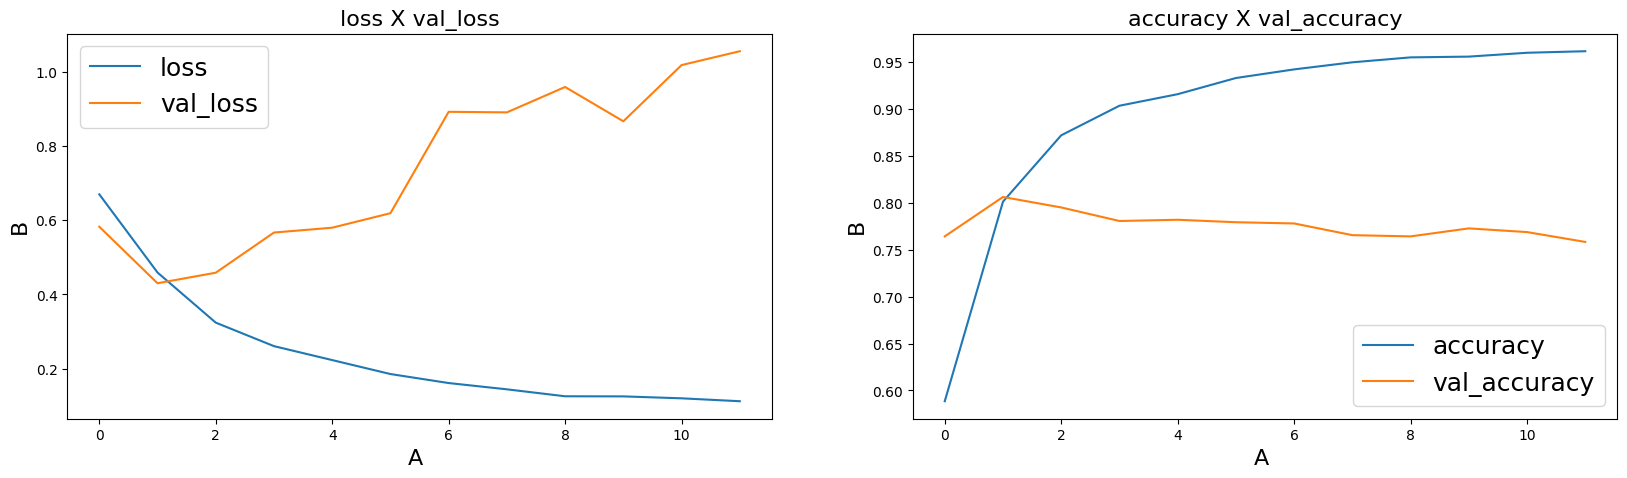

In [18]:
# Predict on validation data
y_pred = model.predict(test_padded)
y_pred = (y_pred > 0.5).astype(int)

# Calculate F1-score
f1 = f1_score(test_data['target'], y_pred)
print(f"F1 Score: {f1}")

plot(history, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])

**Second Model Evaluation**

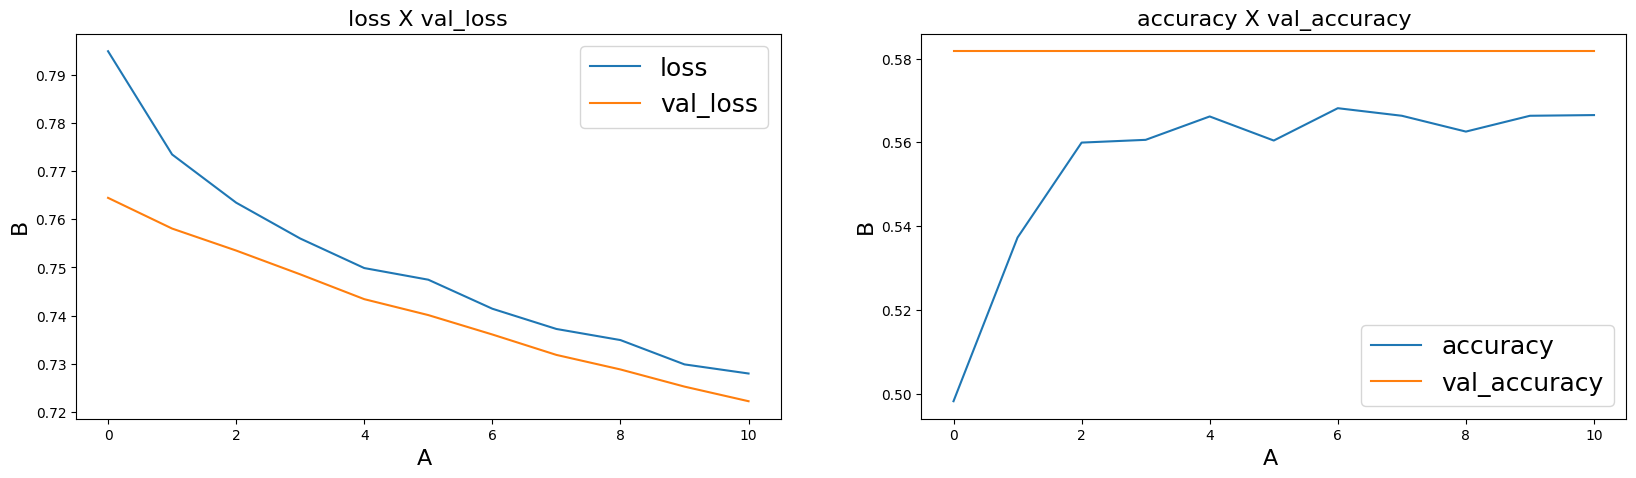

In [19]:

plot(history2, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])

**Third Model**

In [20]:
train_tweets = df_train['Cleaned_text'].values
test_tweets = df_test['Cleaned_text'].values
train_target = df_train['target'].values

In [21]:
# Calculate the length of our vocabulary
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(train_tweets)

vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

12716

In [22]:
def show_metrics(pred_tag, y_test):
    print("F1-score: ", f1_score(pred_tag, y_test))
    print("Precision: ", precision_score(pred_tag, y_test))
    print("Recall: ", recall_score(pred_tag, y_test))
    print("Acuracy: ", accuracy_score(pred_tag, y_test))
    print("-"*50)
    print(classification_report(pred_tag, y_test))
    
def embed(corpus): 
    return word_tokenizer.texts_to_sequences(corpus)

In [23]:
longest_train = max(train_tweets, key=lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train))

train_padded_sentences = pad_sequences(
    embed(train_tweets), 
    length_long_sentence, 
    padding='post'
)
test_padded_sentences = pad_sequences(
    embed(test_tweets), 
    length_long_sentence,
    padding='post'
)

train_padded_sentences

array([[3520,  458,  210, ...,    0,    0,    0],
       [ 137,    2,  181, ...,    0,    0,    0],
       [1314,  509, 1598, ...,    0,    0,    0],
       ...,
       [ 608,  406, 1304, ...,    0,    0,    0],
       [  29,  169, 1905, ...,    0,    0,    0],
       [ 170,   27,  389, ...,    0,    0,    0]], dtype=int32)

In [24]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2024-04-09 14:02:36--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-04-09 14:02:37--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-04-09 14:02:37--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: 'glove.6B.zip'

glov

In [25]:
!unzip -o glove.6B.zip -d glove.6B


Archive:  glove.6B.zip
  inflating: glove.6B/glove.6B.50d.txt  
  inflating: glove.6B/glove.6B.100d.txt  
  inflating: glove.6B/glove.6B.200d.txt  
  inflating: glove.6B/glove.6B.300d.txt  


In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    train_padded_sentences, 
    train_target, 
    test_size=0.25
)

In [27]:
embeddings_dictionary = dict()
embedding_dim = 100

glove_file_path = '/kaggle/working/glove.6B/glove.6B.100d.txt'

# Load GloVe 100D embeddings
with open(glove_file_path, 'r') as fp:
    for line in fp:
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype='float32')
        embeddings_dictionary[word] = vector_dimensions

embedding_matrix = np.zeros((vocab_length, embedding_dim))

for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None and index < vocab_length:
        embedding_matrix[index] = embedding_vector

embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.2687    ,  0.81708002,  0.69896001, ..., -0.40110001,
         0.74656999,  0.31121999],
       [-0.26872   , -0.15542001, -0.23565   , ...,  0.49344   ,
         0.72114003, -0.041749  ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.19814   , -0.33517   , -0.13950001, ..., -0.070356  ,
        -0.18391   ,  0.62439001],
       [-0.34132001,  0.26423001,  0.47813001, ..., -0.92395002,
         0.48275   ,  0.52947998]])

In [28]:
print(embedding_matrix.shape)

(12716, 100)


In [29]:
input_layer = Input(shape=(length_long_sentence,), dtype='int32', name='input_layer')
embedded = Embedding(
    input_dim=embedding_matrix.shape[0],
    output_dim=embedding_matrix.shape[1],
    trainable=False,
    name='embedding_layer'
)(input_layer)

x = Bidirectional(LSTM(length_long_sentence, return_sequences=True, recurrent_dropout=0.2))(embedded)
x = GlobalMaxPool1D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(length_long_sentence, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(length_long_sentence, activation="relu")(x)
x = Dropout(0.5)(x)
output_layer = Dense(1, activation='sigmoid')(x)

model3 = Model(inputs=input_layer, outputs=output_layer)
model3.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

model3.summary()
model3.get_layer("embedding_layer").set_weights([embedding_matrix])

assert np.allclose(embedding_matrix, model3.get_layer("embedding_layer").get_weights()[0])


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 21)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_layer (Embedding)     │ (None, 21, 100)        │     1,271,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 21, 42)         │        20,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 42)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 42)             │           168 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 42)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 21)             │           903 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 21)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 21)             │           462 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 21)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            22 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,293,651 (4.93 MB)

 Trainable params: 1,293,567 (4.93 MB)

 Non-trainable params: 84 (336.00 B)

In [30]:
checkpoint = ModelCheckpoint(
    'model.weights.h5', 
    monitor = 'val_loss', 
    verbose = 1, 
    save_best_only = True,
    save_weights_only=True
)
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss', 
    factor = 0.2, 
    verbose = 1, 
    patience = 5,                        
    min_lr = 0.001
)
history3 = model3.fit(
    X_train, 
    y_train, 
    epochs = 7,
    batch_size = 32,
    validation_data = (X_test, y_test),
    verbose = 1,
    callbacks = [reduce_lr, checkpoint]
)

Epoch 1/7
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5390 - loss: 0.8290
Epoch 1: val_loss improved from inf to 0.65775, saving model to model.weights.h5
179/179 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - accuracy: 0.5392 - loss: 0.8286 - val_accuracy: 0.6565 - val_loss: 0.6577 - learning_rate: 0.0010
Epoch 2/7
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.6571 - loss: 0.6453
Epoch 2: val_loss improved from 0.65775 to 0.55807, saving model to model.weights.h5
179/179 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.6572 - loss: 0.6452 - val_accuracy: 0.7647 - val_loss: 0.5581 - learning_rate: 0.0010
Epoch 3/7
178/179 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7324 - loss: 0.5686
Epoch 3: val_loss improved from 0.55807 to 0.49166, saving model to model.weights.h5
179/179 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.7324 - loss: 0.5685 - val_accuracy: 0.7904 - val_loss: 0.4917 - learning_rate: 0.0010
Epoch 4/7
178/179 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 

**Third Model Evaluation**

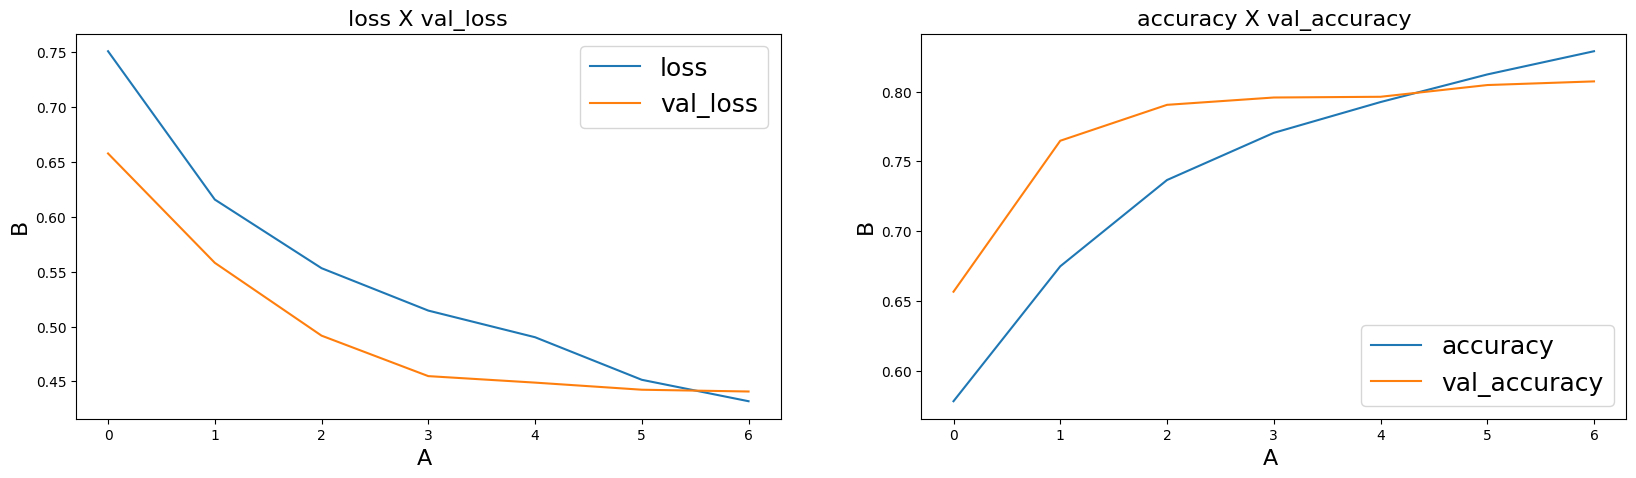

In [31]:
plot(history3, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])

**Creating Submission**

102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


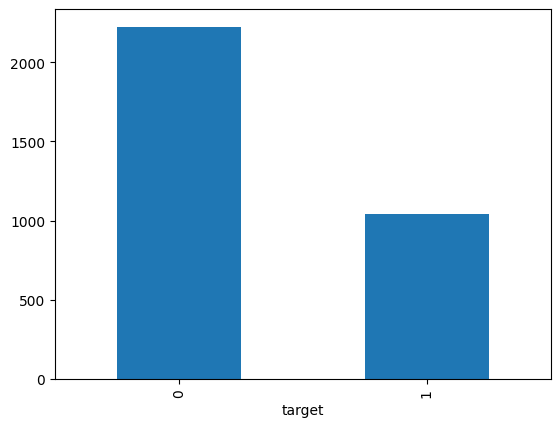

In [32]:
#preds = model3.predict(test_padded_sentences)
submission = pd.read_csv('../input/nlp-getting-started/sample_submission.csv')

model3.load_weights('model.weights.h5')
predictions = model3.predict(test_padded_sentences)
submission.target = (predictions > 0.5).astype(int)

#submission.target = model3.predict_classes(test_padded_sentences)
submission.to_csv("submission.csv", index=False)
submission.target.value_counts().plot.bar();

**Results and Analysis**

The third model, which utilized GloVe embeddings, emerged as the top performer. The initial model exhibited signs of overfitting; despite an increase in training accuracy, there was a decline in validation accuracy. The second model, adjusted through hyperparameter tuning, showed the least favorable performance. Adjusting the learning rate could potentially enhance this model's efficacy.

Therefore, drawing from our analysis, the third model was selected for generating the submission file.

**Conclusion**

The third model, which employed GloVe embeddings, outperformed the others, achieving a public score of 0.79895. There is undoubtedly room for further enhancement. By conducting hyperparameter tuning on the third model, its performance could be improved. Additionally, exploring the use of the BERT model, which has demonstrated considerable advancements in text analysis, could offer further gains.

BERT (Bidirectional Encoder Representations from Transformers) is a groundbreaking model introduced by Google for natural language processing tasks. It represents a significant leap forward because of its ability to understand the nuances and context of words in sentences more effectively than previous models. BERT is trained on a massive corpus of text from the internet, using a technique called masked language modeling, where random words in a sentence are hidden and the model learns to predict them based on the surrounding context. This pre-training on a broad scale enables BERT to capture a deep understanding of language structure and meaning. When fine-tuned on specific tasks, such as sentiment analysis, question answering, or language translation, BERT has achieved state-of-the-art results, showcasing its versatility and power in understanding complex language tasks. Its bi-directional training approach, which considers the full context of a word by looking at the words that come before and after it, sets it apart from earlier models that processed text in only one direction.

**References**

https://www.kaggle.com/code/andreshg/nlp-glove-bert-tf-idf-lstm-explained

https://www.kaggle.com/code/mariapushkareva/nlp-disaster-tweets-with-glove-and-lstm

https://www.kaggle.com/code/aaronfriasr/analysis-of-disaster-tweets-prediction

https://nlp.stanford.edu/projects/glove/